# Importando as bibliotecas

In [1]:

# Manipulação de Dados
import pandas as pd
import numpy as np

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Avisos Importantes
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

%matplotlib inline

# Lendo e entendendo a estrutura da base de dados

Essa base de dados contém as seguintes colunas:



*   'Daily Time Spent on Site': tempo do consumidor no site em ** minutos**
*   'Age': idade do consumidor em **anos**
*   'Area Income': Renda **média** da área geográfica do consumidor
*   'Daily Internet Usage': Tempo **médio** em minutos por dia do consumidor na internet
*   'Ad Topic Line': Cabeçalho do anúncio
*   'City': Cidade do consumidor
*   'Gender': Sexo do consumidor
*   'Country': País do consumidor
*   'Timestamp': Horário que o consumidor clicou no anúncio ou fechou a página
*   'Clicked on Ad': 0 - não clicou ou 1 - clicou










In [2]:
# Leitura do arquivo CSV e análise das primeiras linhas para entendimento da estrutura da base

df_ads = pd.read_csv('ad_10000records.csv')
df_ads.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,Reyesfurt,Female,Guadeloupe,2016-06-29 10:50:45,0
3,59.88,28.0,56180.93,207.17,Balanced empowering success,New Michael,Female,Zambia,2016-06-21 14:32:32,0
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,West Richard,Female,Qatar,2016-07-21 10:54:35,1


In [3]:
# Podemos perceber que não será necessário realizar nenhuma tratativa em relação aos "missings values" ou valores nulos.
# Será necessário alterar alguns tipos de formato para colunas como Timestamp, por exemplo

df_ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  10000 non-null  float64
 1   Age                       10000 non-null  float64
 2   Area Income               10000 non-null  float64
 3   Daily Internet Usage      10000 non-null  float64
 4   Ad Topic Line             10000 non-null  object 
 5   City                      10000 non-null  object 
 6   Gender                    10000 non-null  object 
 7   Country                   10000 non-null  object 
 8   Timestamp                 10000 non-null  object 
 9   Clicked on Ad             10000 non-null  int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 781.4+ KB


In [4]:
# Realizando uma análise estatística mais resumida

df_ads.describe().round(2)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Clicked on Ad
count,10000.00,10000.00,10000.00,10000.00,10000.00
mean,61.66,35.94,53840.05,177.76,0.49
std,15.70,8.57,13343.71,40.82,0.50
min,32.60,19.00,13996.50,105.22,0.00
25%,48.86,29.00,44052.30,140.15,0.00
50%,59.59,35.00,56180.93,178.92,0.00
75%,76.58,42.00,61840.26,212.67,1.00
max,90.97,60.00,79332.33,269.96,1.00


In [5]:
# Coeficiente de variação
# Gosto de realizar essa conta rapidamente para verificar dentre as colunas aquele que pode estar com os dados mais heterogêneos. Importante caso você vá realizar cálculos estátisticos em cima delas
# Vamos desconsiderar a coluna "Clicked on Ad", pois ela é uma coluna de classificação apenas (varia entre 0 e 1)
print("Coeficiente de variação (desvio padrão/média)\n")

for col in df_ads.columns:
  if (df_ads[col].dtype in [np.float64, np.int64]) and (col != "Clicked on Ad"):
    cv = (df_ads[col].std() / df_ads[col].mean()) * 100
    print(f'{col}: {cv:.2f}%')

Coeficiente de variação (desvio padrão/média)

Daily Time Spent on Site: 25.47%
Age: 23.85%
Area Income: 24.78%
Daily Internet Usage: 22.96%


# ETL - Realizando os ajustes na base necessários

In [32]:
def create_age_range(x):
  if x <= 10:
    return '0-10'
  elif x <= 20:
    return '11-20'
  elif x <= 30:
    return '21-30'
  elif x <= 40:
    return '31-40'
  elif x <= 50:
    return '41-50'
  elif x <= 60:
    return '51-60'
  elif x <= 70:
    return '61-70'
  else:
    return '71+'

def create_hour_range(x):
  if x <= 5:
    return 'Madrugada'
  elif x <= 12:
    return 'Manhã'
  elif x <= 18:
    return 'Tarde'
  else:
    return 'Noite'


df_ads['Timestamp'] = pd.to_datetime(df_ads['Timestamp'])

df_ads['Day'] = df_ads['Timestamp'].apply(lambda x: x.day)
df_ads['Age Range'] = df_ads['Age'].apply(lambda x: create_age_range(x))
df_ads['Day of Week'] = df_ads['Timestamp'].apply(lambda x: x.weekday()).map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
df_ads['Month'] = df_ads['Timestamp'].apply(lambda x: x.month)
df_ads['Year'] = df_ads['Timestamp'].apply(lambda x: x.year)
df_ads['Hour'] = df_ads['Timestamp'].apply(lambda x: x.hour)
df_ads['Hour Range'] = df_ads['Hour'].apply(lambda x: create_hour_range(x))

In [7]:
df_ads.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad,Day,Age Range,Day of Week,Month,Year,Hour
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0,9,31-40,Thursday,6,2016,21
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0,16,31-40,Saturday,1,2016,17
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,Reyesfurt,Female,Guadeloupe,2016-06-29 10:50:45,0,29,21-30,Wednesday,6,2016,10
3,59.88,28.0,56180.93,207.17,Balanced empowering success,New Michael,Female,Zambia,2016-06-21 14:32:32,0,21,21-30,Tuesday,6,2016,14
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,West Richard,Female,Qatar,2016-07-21 10:54:35,1,21,21-30,Thursday,7,2016,10


# EDA (Exploratory Data Analysis) - Geral

In [71]:
# sns.pairplot(data = df_ads, hue = 'Clicked on Ad')
# plt.tight_layout()
# plt.show()

In [53]:
# Aqui estamos procurando entender a distribuição da base em relação ao gênero das pessoas
# Pode-se observar que possuimos mais pessoas do gêmero feminino do que masculino

gender_number = df_ads['Gender'].value_counts()
gender_number
gender_distrib = df_ads['Gender'].value_counts(normalize = True).round(2)
gender_distrib

,proportion
Gender,
Female,0.54
Male,0.46


In [70]:
# Além de verificarmos a quantidade de homens e mulheres, foi analisado a taxa de cliques pois isso seria mais representativo quando falamos sobre resultados

df_ads_group = df_ads.groupby('Gender')['Clicked on Ad'].agg(['count', 'sum'])
df_ads_group.columns = ['Pessoas','Cliques']
df_ads_group['Taxa de cliques'] = (df_ads_group['Cliques'] / df_ads_group['Pessoas']).round(2)
df_ads_group

,Pessoas,Cliques,Taxa de cliques
Gender,,,
Female,5376,2767,0.51
Male,4624,2150,0.46


Text(0.5, 0, 'Total de cliques')

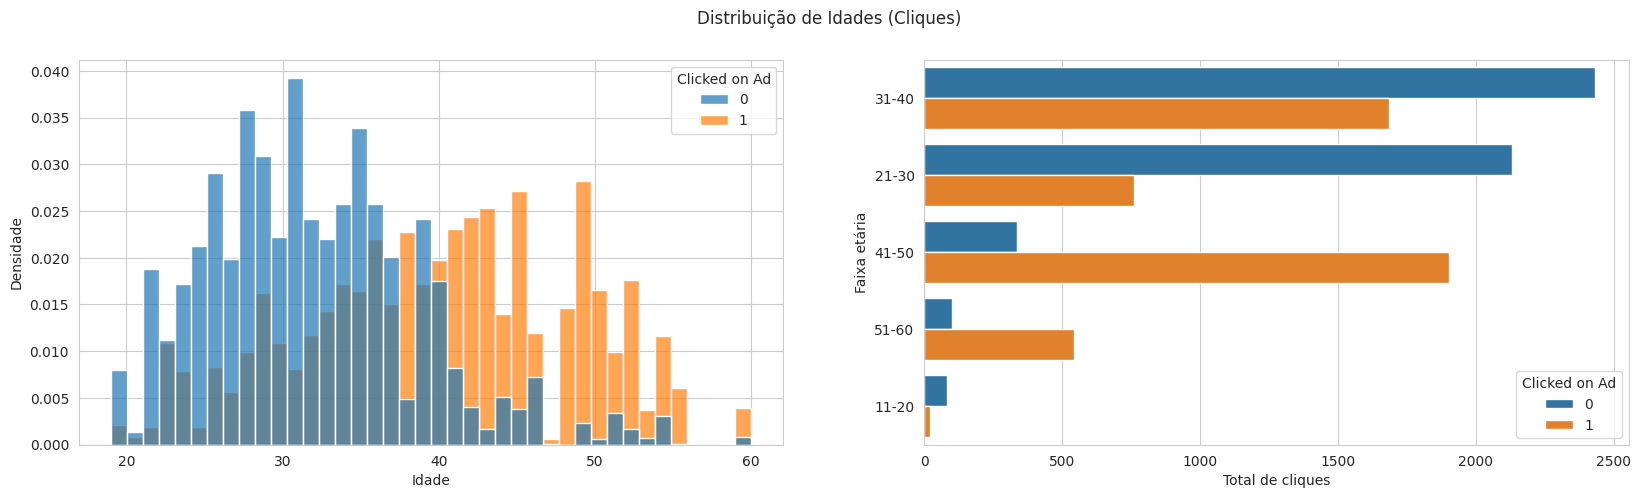

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

In [89]:
# Aqui estamos realizando um histograma de idades para analisar as idades
# A predominância de idades que temos na base em geral está entre 20 a 40 anos
# A predominância de cliques contra não cliques está na faixa etária acima de 40 anos

# Cria uma figura e dois subplots lado a lado
rows, cols = 1,2
fig, axs = plt.subplots(rows, cols, figsize=(20, 5)) # subplots(numero de linhas, numero de colunas, tamanho da figura)
fig.suptitle('Distribuição de Idades (Cliques)')

# Gráfico 1
ax1 = axs[0]
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
age_distr_plot = sns.histplot(ax = ax1,data = df_ads, x = 'Age', bins = 40, kde = False, stat= 'density', hue = 'Clicked on Ad', alpha = 0.7)
ax1.set_ylabel("Densidade")
ax1.set_xlabel("Idade")


# Colocar gráfico da faixa etária do lado para dar mais força na comparação
# Gráfico 2
ax2 = axs[1]
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
age_distr_barplot = sns.countplot(ax = ax2,data = df_ads, y = 'Age Range', orient = 'h', hue = 'Clicked on Ad', order= df_ads['Age Range'].value_counts().index)
ax2.set_ylabel('Faixa etária')
ax2.set_xlabel('Total de cliques')



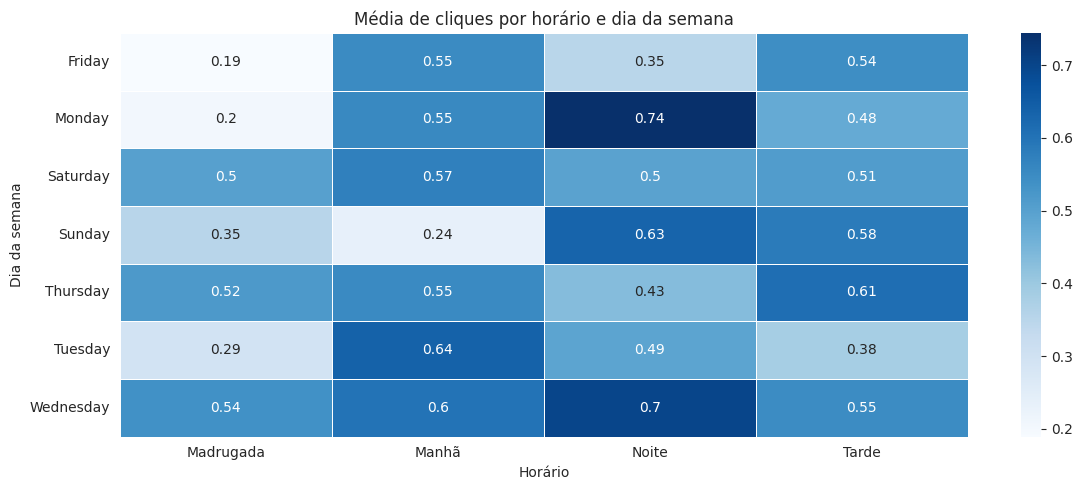

In [51]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
hour_weekday_plot = sns.heatmap(data = df_ads.pivot_table(index = 'Day of Week', columns = 'Hour Range', values = 'Clicked on Ad', aggfunc = 'mean'), annot = True, cmap = 'Blues', linewidth=.5)
plt.title('Média de cliques por horário e dia da semana')
plt.xlabel('Horário')
plt.ylabel('Dia da semana')
plt.tight_layout()
plt.show()

# EDA (Exploratory Data Analysis) - Comparando comportamento de gêneros

O objetivo aqui será analisar o comportamento de cada gênero e seus respectivos parâmetros e depois os dois juntos. Estamos levando em consideração se você quisesse realizar um anúncio para segmentando algum público específico, mas no final juntaremos os dois para quem quisesse fazer um anúncio independente do sexo

In [81]:
# Aqui foi separado em grupos de pessoas que clicaram e que não clicaram, vou utilizar apenas as que clicaram
# A ideia de analisar o grupo que não clicou seria mais para entender as piores idades, horários e etc, uma análise mais voltada para o que evitar

df_ads_clicked = df_ads[df_ads['Clicked on Ad'] == 1]
df_ads_not_clicked = df_ads[df_ads['Clicked on Ad'] == 0]

df_ads_clicked_female = df_ads_clicked[df_ads_clicked['Gender'] == 'Female']
df_ads_clicked_male = df_ads_clicked[df_ads_clicked['Gender'] == 'Male']

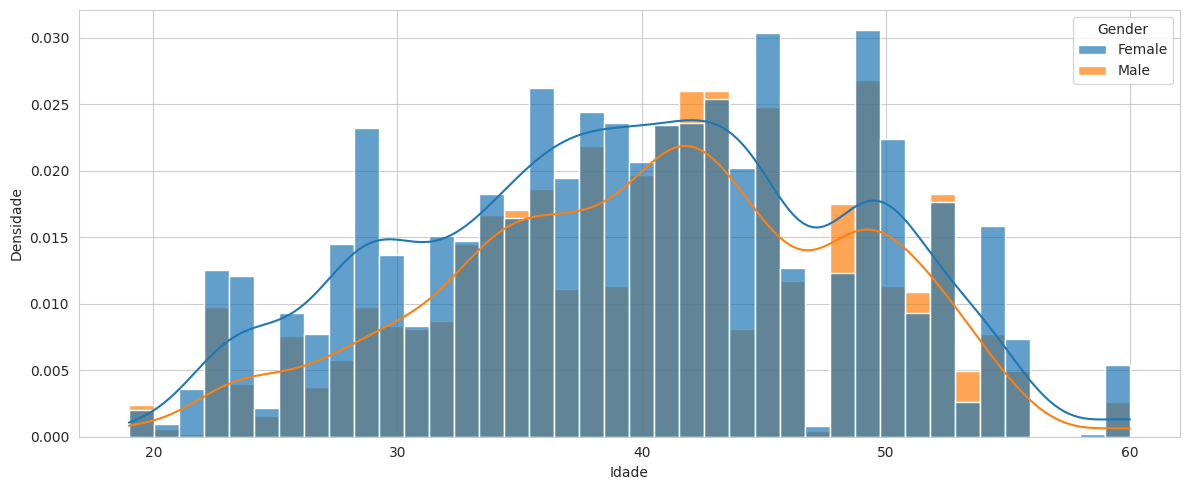

In [88]:

sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
age_distr_plot = sns.histplot(data = df_ads_clicked, x = 'Age', bins = 40, kde = True, stat= 'density', hue = 'Gender', alpha = 0.7)
plt.ylabel("Densidade")
plt.xlabel("Idade")

plt.tight_layout()
plt.show()

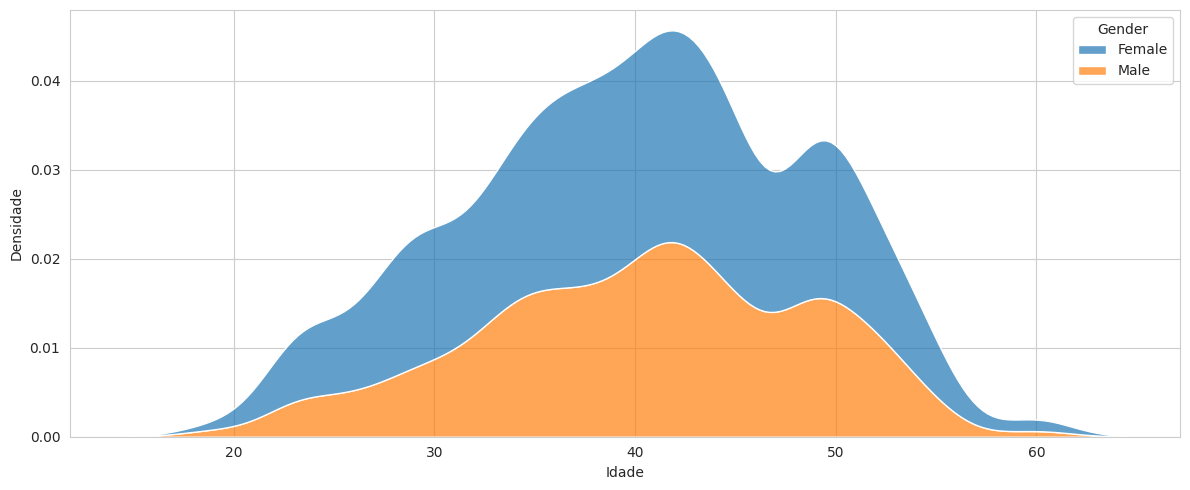

In [92]:

sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
age_distr_plot = sns.kdeplot(data = df_ads_clicked, x = 'Age', hue = 'Gender', multiple = 'stack',alpha = 0.7)
plt.ylabel("Densidade")
plt.xlabel("Idade")

plt.tight_layout()
plt.show()

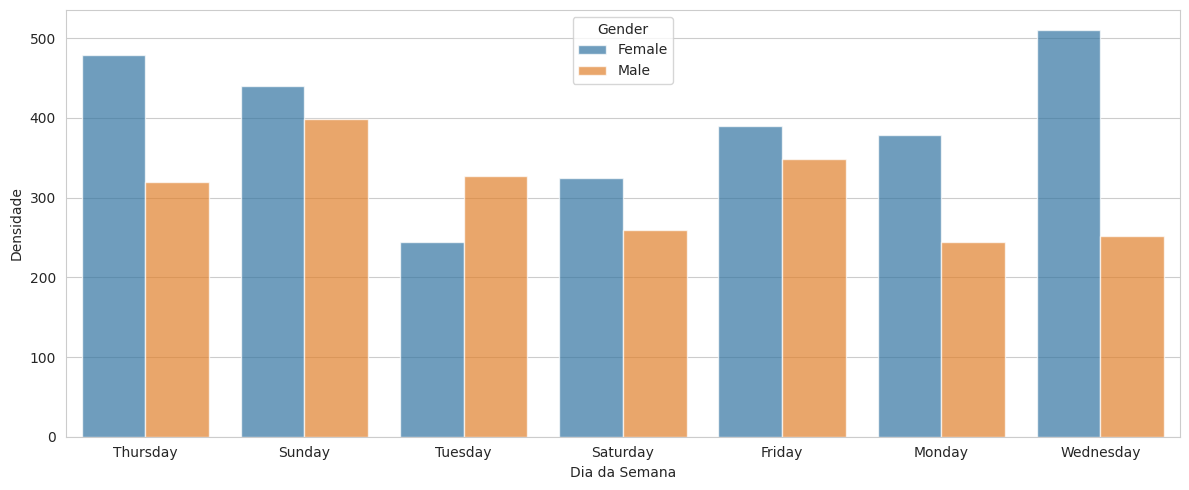

In [95]:

sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
age_distr_plot = sns.countplot(data = df_ads_clicked, x = 'Day of Week', hue = 'Gender',alpha = 0.7)
plt.ylabel("Densidade")
plt.xlabel("Dia da Semana")

plt.tight_layout()
plt.show()

## Correlações

In [16]:
# Em algumas pesquisas que realizei, encontrei estes valores que são legais para nos apoiar no quão forte ou fraca seria a nossa correlação

data = {'Correlation Strength': ['Very Strong', 'Strong', 'Moderate', 'Weak', 'Very Weak'],
        'Correlation Coefficient (r)': ['0.8 to 1.0 or -0.8 to -1.0', '0.6 to 0.79 or -0.6 to -0.79', '0.4 to 0.59 or -0.4 to -0.59', '0.2 to 0.39 or -0.2 to -0.39', '0 to 0.19 or 0 to -0.19']}

df_corr_numbers = pd.DataFrame(data)
df_corr_numbers

,Correlation Strength,Correlation Coefficient (r)
0,Very Strong,0.8 to 1.0 or -0.8 to -1.0
1,Strong,0.6 to 0.79 or -0.6 to -0.79
2,Moderate,0.4 to 0.59 or -0.4 to -0.59
3,Weak,0.2 to 0.39 or -0.2 to -0.39
4,Very Weak,0 to 0.19 or 0 to -0.19


In [17]:
# Como estamos analisando apenas o ano de 2016, essa coluna será retirada

df_ads_pre_corr = df_ads.drop('Year', axis = 1)
df_ads_corr = df_ads_pre_corr.corr(numeric_only = True)
df_ads_corr

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Clicked on Ad,Day,Month,Hour
Daily Time Spent on Site,1.000000,0.100129,0.016288,-0.058930,0.091034,-0.011805,0.006643,0.015781
Age,0.100129,1.000000,-0.051198,-0.106603,0.460383,-0.016857,-0.018134,0.089600
Area Income,0.016288,-0.051198,1.000000,0.041495,-0.067631,0.005539,0.006062,0.054176
Daily Internet Usage,-0.058930,-0.106603,0.041495,1.000000,-0.129412,0.020304,0.023890,-0.026687
Clicked on Ad,0.091034,0.460383,-0.067631,-0.129412,1.000000,-0.014313,-0.044869,0.135601
Day,-0.011805,-0.016857,0.005539,0.020304,-0.014313,1.000000,-0.052869,0.019410
Month,0.006643,-0.018134,0.006062,0.023890,-0.044869,-0.052869,1.000000,-0.115381
Hour,0.015781,0.089600,0.054176,-0.026687,0.135601,0.019410,-0.115381,1.000000


<Axes: >

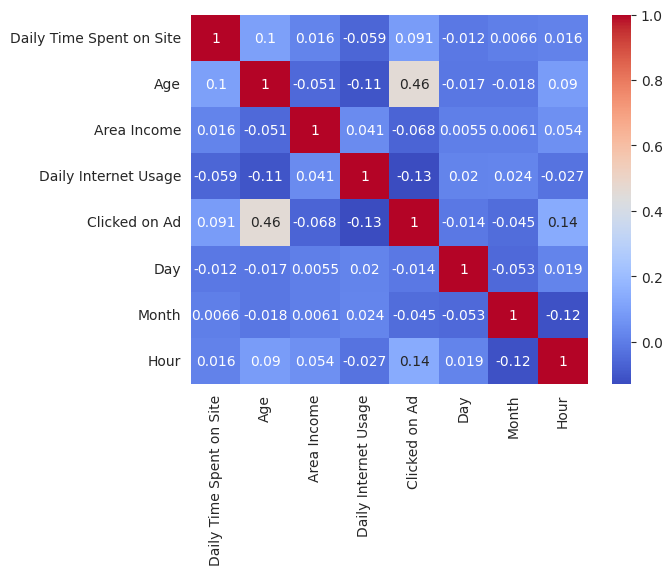

In [18]:
# Pode-se verificar que não temos fortes correlações entre as variáveis desta fonte de dados
# A mais relevante seria entre "Clicked on Ad" e "Age", mas baseada na tabela acima, ela seria considerada moderada

heat_map_corr = sns.heatmap(df_ads_corr, annot = True, cmap = 'coolwarm')
heat_map_corr

<Figure size 800x500 with 0 Axes>

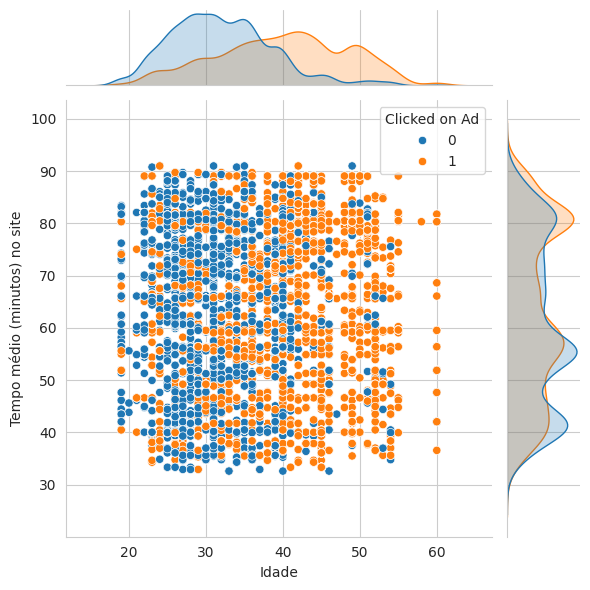

In [80]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))
hour_weekday_plot = sns.jointplot(data = df_ads, x = 'Age', y = 'Daily Time Spent on Site', kind = 'scatter', hue = 'Clicked on Ad')
# plt.title('Média de cliques por horário e dia da semana')
plt.xlabel('Idade')
plt.ylabel('Tempo médio (minutos) no site')
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

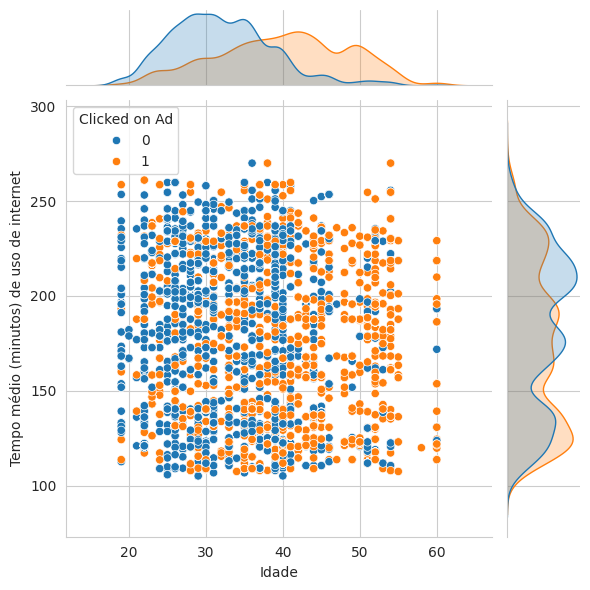

In [79]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))
hour_weekday_plot = sns.jointplot(data = df_ads, x = 'Age', y = 'Daily Internet Usage', kind = 'scatter', hue = 'Clicked on Ad')
# plt.title('Média de cliques por horário e dia da semana')
plt.xlabel('Idade')
plt.ylabel('Tempo médio (minutos) de uso de internet')
plt.tight_layout()
plt.show()

# Machine Learning

In [104]:
df_ads_ml = df_ads.copy()

In [105]:
df_ads_ml['Male'] = pd.get_dummies(df_ads_ml['Gender'], drop_first = True, dtype = 'int64')
df_ads_ml.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad,Day,Age Range,Day of Week,Month,Year,Hour,Hour Range,Male
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0,9,31-40,Thursday,6,2016,21,Noite,1
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0,16,31-40,Saturday,1,2016,17,Tarde,1
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,Reyesfurt,Female,Guadeloupe,2016-06-29 10:50:45,0,29,21-30,Wednesday,6,2016,10,Manhã,0
3,59.88,28.0,56180.93,207.17,Balanced empowering success,New Michael,Female,Zambia,2016-06-21 14:32:32,0,21,21-30,Tuesday,6,2016,14,Tarde,0
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,West Richard,Female,Qatar,2016-07-21 10:54:35,1,21,21-30,Thursday,7,2016,10,Manhã,0


In [109]:
# Features
columns = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Day','Hour', 'Month','Year','Male']
X = df_ads_ml[columns]

# To predict
y = df_ads_ml['Clicked on Ad']

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42 )

In [111]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [112]:
y_pred = log_reg.predict(X_test)

In [117]:
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

In [118]:
print(conf_matrix)

[[1184  359]
 [ 461  996]]


In [119]:
print(class_report)

              precision    recall  f1-score   support

           0       0.72      0.77      0.74      1543
           1       0.74      0.68      0.71      1457

    accuracy                           0.73      3000
   macro avg       0.73      0.73      0.73      3000
weighted avg       0.73      0.73      0.73      3000

